In [1]:
import pandas as pd
import numpy as np
from nba_api.stats.endpoints import leaguedashplayerstats
import time

seasons = ['2023-24', '2022-23'] # Using completed seasons for reliable data

# --- Step 1: Fetch TOTALS data for filtering ---
print("--- Fetching Mode: Totals ---")
totals_df = pd.DataFrame()
for season in seasons:
    print(f"-> Processing {season} totals...")
    try:
        player_totals = leaguedashplayerstats.LeagueDashPlayerStats(
            season=season,
            per_mode_detailed='Totals',
            season_type_all_star='Regular Season'
        ).get_data_frames()[0]
        player_totals['SEASON'] = season
        totals_df = pd.concat([totals_df, player_totals], ignore_index=True)
        time.sleep(1)
    except Exception as e:
        print(f"Error fetching totals for {season}: {e}")

player_filters = totals_df[['PLAYER_ID', 'PLAYER_NAME', 'SEASON', 'MIN', 'GP']].copy()
print(f"Totals fetched. Shape: {player_filters.shape}")


# --- Step 2: Fetch Per100Possessions data for modeling ---
print("\n--- Fetching Mode: Per 100 Possessions ---")
per_100_df = pd.DataFrame()
for season in seasons:
    print(f"-> Processing {season} Per100...")
    try:
        player_per_100 = leaguedashplayerstats.LeagueDashPlayerStats(
            season=season,
            per_mode_detailed='Per100Possessions',
            season_type_all_star='Regular Season'
        ).get_data_frames()[0]
        player_per_100['SEASON'] = season
        per_100_df = pd.concat([per_100_df, player_per_100], ignore_index=True)
        time.sleep(1)
    except Exception as e:
        print(f"Error fetching Per100 data for {season}: {e}")
        
print(f"Per 100 Possessions data fetched. Shape: {per_100_df.shape}")


# --- Step 3: Merge the two datasets ---
merged_df = pd.merge(
    per_100_df,
    player_filters,
    on=['PLAYER_ID', 'PLAYER_NAME', 'SEASON'],
    suffixes=('_PER100', '_TOTAL')
)
print(f"\nShape after merging: {merged_df.shape}")


# --- Step 4: Data Cleaning, Filtering, and Engineering ---

# Convert all potential numeric columns to numbers
cols_to_convert = [col for col in merged_df.columns if col not in ['PLAYER_ID', 'PLAYER_NAME', 'TEAM_ID', 'TEAM_ABBREVIATION', 'SEASON']]
for col in cols_to_convert:
    merged_df[col] = pd.to_numeric(merged_df[col], errors='coerce')

MIN_THRESHOLD = 800
GP_THRESHOLD = 40 
qualified_players_df = merged_df[
    (merged_df['MIN_TOTAL'] >= MIN_THRESHOLD) &
    (merged_df['GP_TOTAL'] >= GP_THRESHOLD)
].copy()

print(f"Shape after filtering (MIN >= {MIN_THRESHOLD}, GP >= {GP_THRESHOLD}): {qualified_players_df.shape}")

# --- Feature Engineering (USING CORRECT COLUMN NAMES) ---
df = qualified_players_df.copy()
df.set_index('PLAYER_NAME', inplace=True)

df['FG3_RATE'] = df['FG3A'] / df['FGA']
df['AST_TO_TOV'] = df['AST'] / (df['TOV'] + 1e-6)
df['FTA_RATE'] = df['FTA'] / df['FGA']

df.fillna(0, inplace=True)
df.replace([np.inf, -np.inf], 0, inplace=True)

# --- Final Feature Selection & Scaling (USING CORRECT COLUMN NAMES) ---
features_for_clustering = [
    'FG_PCT', 'FG3_PCT', 'FT_PCT',
    'OREB', 'DREB', 'REB',
    'AST', 'STL', 'BLK', 'PF',
    'PTS', 'PLUS_MINUS',
    'FG3_RATE', 'AST_TO_TOV', 'FTA_RATE'
]

model_df = df[features_for_clustering]

print(f"\nShape of final features dataframe for the model: {model_df.shape}")

# Scaling the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(model_df)
scaled_df = pd.DataFrame(scaled_data, index=model_df.index, columns=model_df.columns)

print("\n--- VICTORY! ---")
print("Data pipeline successful. First 5 rows of scaled data:")
scaled_df.head()

--- Fetching Mode: Totals ---
-> Processing 2023-24 totals...
-> Processing 2022-23 totals...
Totals fetched. Shape: (3039, 5)

--- Fetching Mode: Per 100 Possessions ---
-> Processing 2023-24 Per100...
-> Processing 2022-23 Per100...
Per 100 Possessions data fetched. Shape: (3039, 68)

Shape after merging: (4421, 70)
Shape after filtering (MIN >= 800, GP >= 40): (681, 70)

Shape of final features dataframe for the model: (681, 15)

--- VICTORY! ---
Data pipeline successful. First 5 rows of scaled data:


,FG_PCT,FG3_PCT,FT_PCT,OREB,DREB,REB,AST,STL,BLK,PF,PTS,PLUS_MINUS,FG3_RATE,AST_TO_TOV,FTA_RATE
PLAYER_NAME,,,,,,,,,,,,,,,
A'ja Wilson,1.136147,-0.257921,0.401852,0.689777,1.916126,1.583212,-0.915704,0.956352,2.873893,-0.454167,1.925022,3.029837,-1.776558,-0.052743,1.993006
Aaron Gordon,1.121990,-0.448167,-1.057574,1.006782,-0.093543,0.345480,0.174432,-0.449077,-0.000169,-0.713419,-0.121517,1.428515,-1.044337,-0.052741,1.112819
Aaron Holiday,-0.435353,0.474524,1.434823,-0.831847,-1.079418,-1.072754,0.065419,0.113095,-0.919869,0.669259,-0.501589,0.483736,0.627237,-0.052741,-0.842120
Aaron Nesmith,0.272530,0.778917,0.108072,-0.388040,-0.586481,-0.557032,-0.915704,-0.027448,0.229756,1.619850,-0.267699,0.595828,0.681758,-0.052742,-0.275394
Aaron Wiggins,1.206936,1.473314,0.183886,0.119168,-0.624399,-0.350744,-0.588663,0.956352,-0.345056,-0.194915,-0.179990,0.579815,-0.319423,-0.052742,-0.485824


In [2]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# --- Applying PCA ---
# We want to reduce our 15 dimensions down to 2 for visualization.
pca = PCA(n_components=2)

# Fit PCA on our scaled data and transform it
principal_components = pca.fit_transform(scaled_df)

# Create a new DataFrame with the PCA results
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'], index=scaled_df.index)

print("PCA complete. First 5 rows of the PCA DataFrame:")
pca_df.head()

PCA complete. First 5 rows of the PCA DataFrame:


,PC1,PC2
PLAYER_NAME,,
A'ja Wilson,3.829209,2.951950
Aaron Gordon,1.689903,0.796521
Aaron Holiday,-2.252906,-0.368824
Aaron Nesmith,-0.427489,-1.016866
Aaron Wiggins,-0.465321,0.195570


In [3]:
# This tells us how much of the original variance is captured by each principal component.
explained_variance = pca.explained_variance_ratio_

print(f"Explained variance by PC1: {explained_variance[0]:.2%}")
print(f"Explained variance by PC2: {explained_variance[1]:.2%}")
print(f"Total variance captured by our 2D plot: {explained_variance.sum():.2%}")

Explained variance by PC1: 35.80%
Explained variance by PC2: 13.79%
Total variance captured by our 2D plot: 49.59%


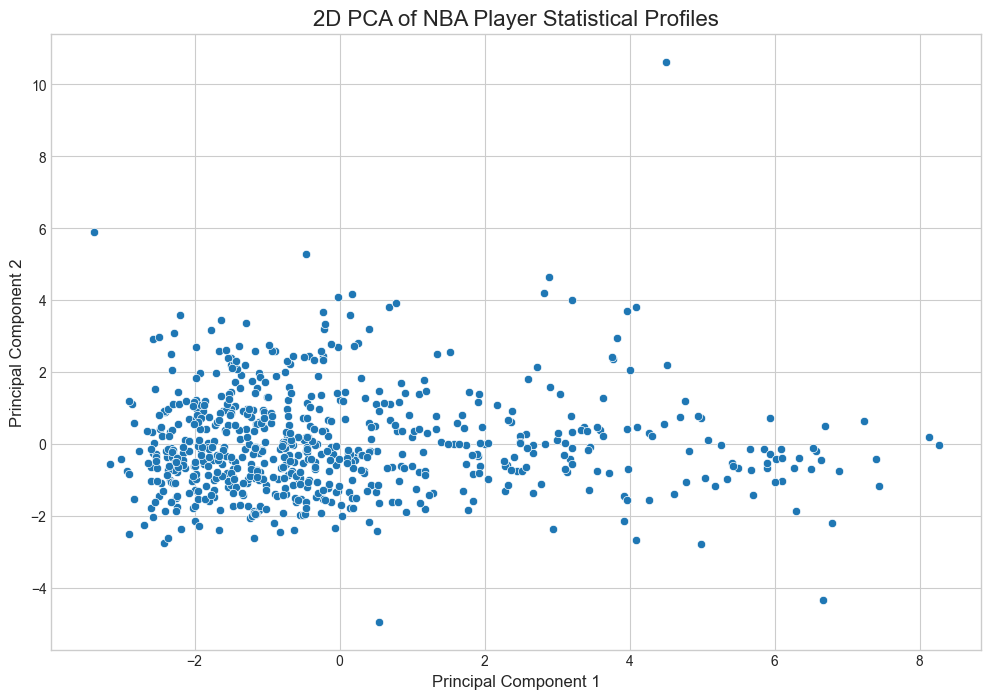

In [4]:
# --- Visualizing the PCA Results ---
plt.style.use('seaborn-v0_8-whitegrid') 
plt.figure(figsize=(12, 8))

sns.scatterplot(x='PC1', y='PC2', data=pca_df)

plt.title('2D PCA of NBA Player Statistical Profiles', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.show()

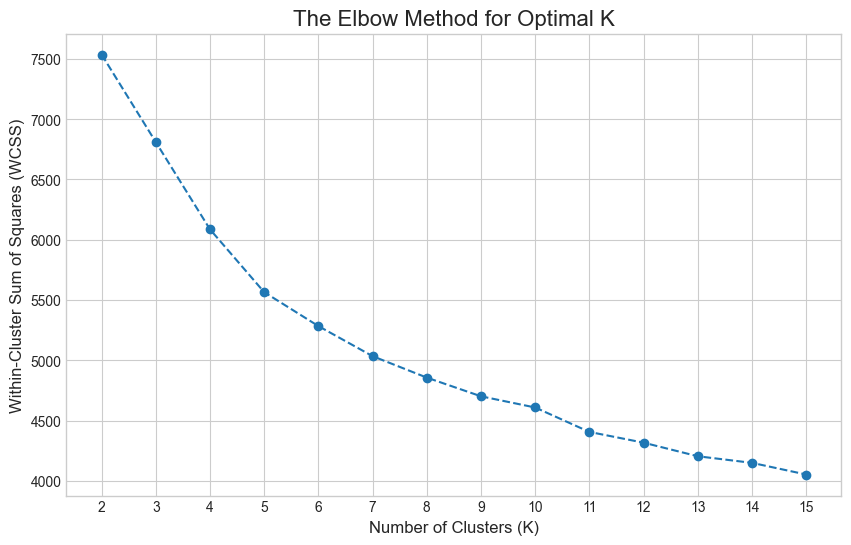

In [5]:
from sklearn.cluster import KMeans

# --- The Elbow Method ---
wcss = []
k_range = range(2, 16) 

# Cluster on the scaled 15-dimensional data
for i in k_range:
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(scaled_df)
    wcss.append(kmeans.inertia_) # inertia_ is the WCSS

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(k_range, wcss, marker='o', linestyle='--')
plt.title('The Elbow Method for Optimal K', fontsize=16)
plt.xlabel('Number of Clusters (K)', fontsize=12)
plt.ylabel('Within-Cluster Sum of Squares (WCSS)', fontsize=12)
plt.xticks(k_range)
plt.grid(True)
plt.show()

Silhouette Score for K=2: 0.3581
Silhouette Score for K=3: 0.1652
Silhouette Score for K=4: 0.1681
Silhouette Score for K=5: 0.1665
Silhouette Score for K=6: 0.1282
Silhouette Score for K=7: 0.1231
Silhouette Score for K=8: 0.1237
Silhouette Score for K=9: 0.1133
Silhouette Score for K=10: 0.1123
Silhouette Score for K=11: 0.1136
Silhouette Score for K=12: 0.1027
Silhouette Score for K=13: 0.1148
Silhouette Score for K=14: 0.0963
Silhouette Score for K=15: 0.1138


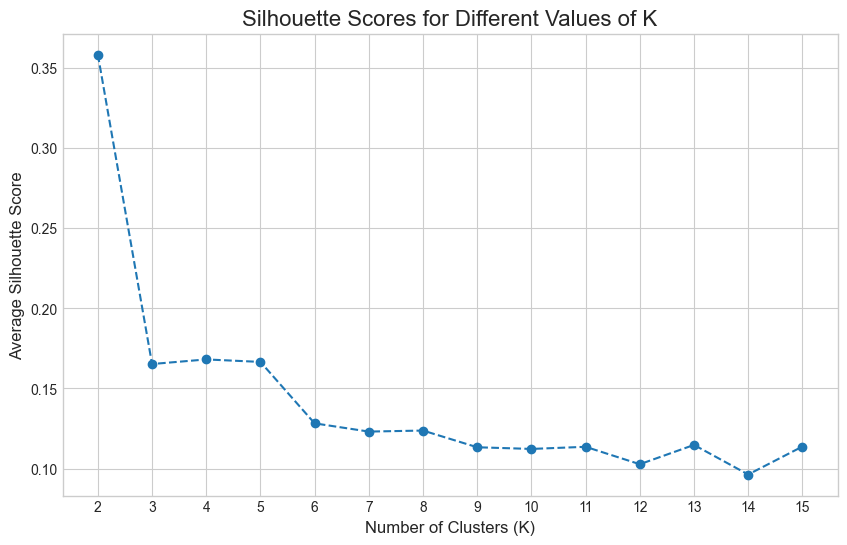

In [6]:
from sklearn.metrics import silhouette_score

# --- Silhouette Analysis ---
silhouette_scores = []

for i in k_range:
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(scaled_df)
    score = silhouette_score(scaled_df, kmeans.labels_)
    silhouette_scores.append(score)
    print(f"Silhouette Score for K={i}: {score:.4f}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores, marker='o', linestyle='--')
plt.title('Silhouette Scores for Different Values of K', fontsize=16)
plt.xlabel('Number of Clusters (K)', fontsize=12)
plt.ylabel('Average Silhouette Score', fontsize=12)
plt.xticks(k_range)
plt.grid(True)
plt.show()

In [7]:
# --- Running Final K-Means Model ---
FINAL_K = 8 # Or your chosen K

kmeans = KMeans(n_clusters=FINAL_K, init='k-means++', random_state=42, n_init=10)
kmeans.fit(scaled_df)

# Get the cluster assignments for each player
cluster_labels = kmeans.labels_

# --- Add the cluster labels back to our DataFrames ---
# Add to PCA dataframe for visualization
pca_df['Cluster'] = cluster_labels

# Add to our original (unscaled) model dataframe for interpretation
model_df['Cluster'] = cluster_labels

# Add to the full dataframe to access player names and other stats
df['Cluster'] = cluster_labels

print(f"\nSuccessfully clustered players into {FINAL_K} groups.")
print("PCA DataFrame with Cluster labels:")
pca_df.head()


Successfully clustered players into 8 groups.
PCA DataFrame with Cluster labels:


C:\Users\osipc\AppData\Local\Temp\ipykernel_28576\2991009043.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df['Cluster'] = cluster_labels


,PC1,PC2,Cluster
PLAYER_NAME,,,
A'ja Wilson,3.829209,2.951950,1
Aaron Gordon,1.689903,0.796521,2
Aaron Holiday,-2.252906,-0.368824,4
Aaron Nesmith,-0.427489,-1.016866,4
Aaron Wiggins,-0.465321,0.195570,4


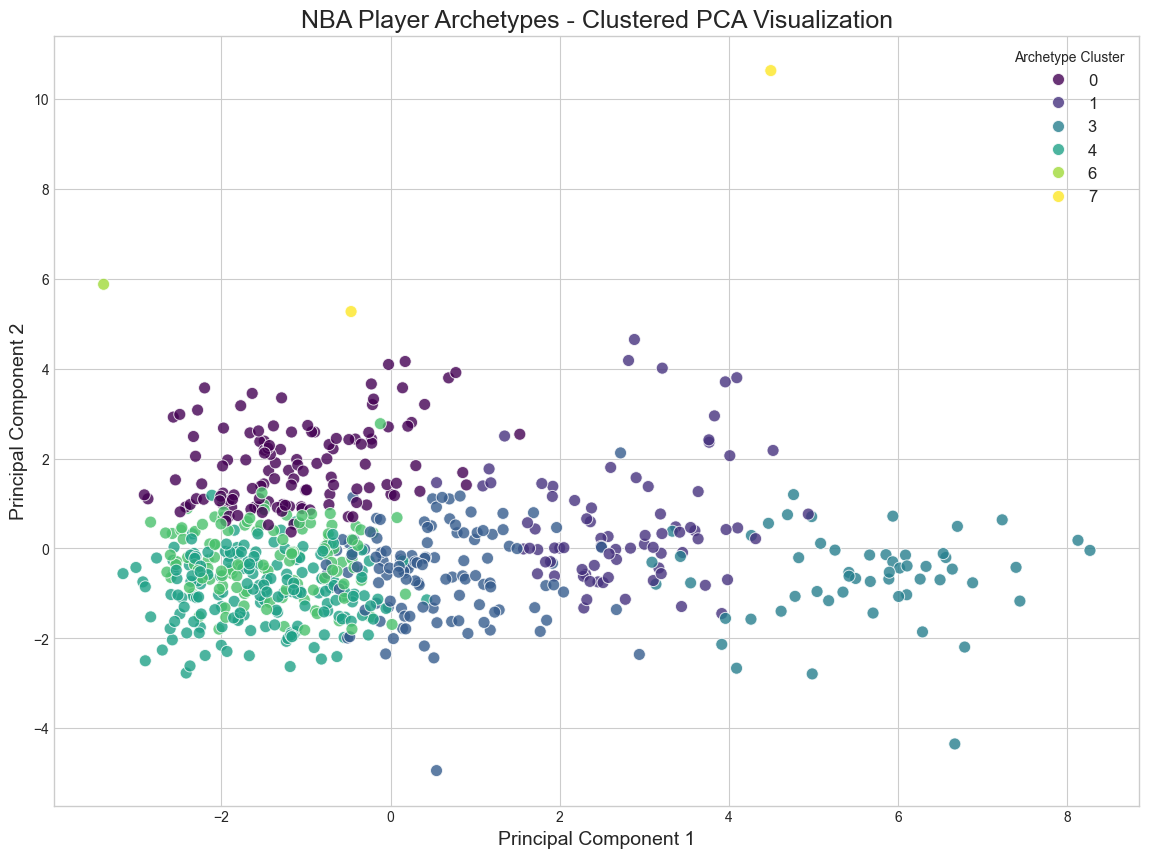

In [8]:
# --- Visualizing the Clusters on the PCA Plot ---
plt.figure(figsize=(14, 10))

sns.scatterplot(
    x='PC1', 
    y='PC2', 
    hue='Cluster', 
    data=pca_df, 
    palette='viridis', 
    s=75,
    alpha=0.8 
)

plt.title('NBA Player Archetypes - Clustered PCA Visualization', fontsize=18)
plt.xlabel('Principal Component 1', fontsize=14)
plt.ylabel('Principal Component 2', fontsize=14)
plt.legend(title='Archetype Cluster', fontsize=12)
plt.show()

In [9]:
# Add the cluster labels to the scaled_df DataFrame
scaled_df['Cluster'] = cluster_labels

# Verify it's there
print("Cluster column successfully added to scaled_df.")
scaled_df.head()

Cluster column successfully added to scaled_df.


,FG_PCT,FG3_PCT,FT_PCT,OREB,DREB,REB,AST,STL,BLK,PF,PTS,PLUS_MINUS,FG3_RATE,AST_TO_TOV,FTA_RATE,Cluster
PLAYER_NAME,,,,,,,,,,,,,,,,
A'ja Wilson,1.136147,-0.257921,0.401852,0.689777,1.916126,1.583212,-0.915704,0.956352,2.873893,-0.454167,1.925022,3.029837,-1.776558,-0.052743,1.993006,1
Aaron Gordon,1.121990,-0.448167,-1.057574,1.006782,-0.093543,0.345480,0.174432,-0.449077,-0.000169,-0.713419,-0.121517,1.428515,-1.044337,-0.052741,1.112819,2
Aaron Holiday,-0.435353,0.474524,1.434823,-0.831847,-1.079418,-1.072754,0.065419,0.113095,-0.919869,0.669259,-0.501589,0.483736,0.627237,-0.052741,-0.842120,4
Aaron Nesmith,0.272530,0.778917,0.108072,-0.388040,-0.586481,-0.557032,-0.915704,-0.027448,0.229756,1.619850,-0.267699,0.595828,0.681758,-0.052742,-0.275394,4
Aaron Wiggins,1.206936,1.473314,0.183886,0.119168,-0.624399,-0.350744,-0.588663,0.956352,-0.345056,-0.194915,-0.179990,0.579815,-0.319423,-0.052742,-0.485824,4


In [10]:
# --- Analyzing the Statistical Profile of Each Cluster ---

archetype_summary = scaled_df.groupby('Cluster').mean()

archetype_summary.style.background_gradient(cmap='viridis', axis=0)

,FG_PCT,FG3_PCT,FT_PCT,OREB,DREB,REB,AST,STL,BLK,PF,PTS,PLUS_MINUS,FG3_RATE,AST_TO_TOV,FTA_RATE
Cluster,,,,,,,,,,,,,,,
0,-0.048872,0.332454,0.639307,-0.623238,-0.299036,-0.456383,1.109840,0.168632,-0.411809,-0.773354,1.059133,0.673182,-0.094119,-0.052741,0.327071
1,0.904069,0.203244,-0.107136,1.115928,1.446707,1.436655,-0.326018,-0.361904,1.014120,0.640818,0.589405,0.208876,-0.890568,-0.052742,0.668376
2,-0.232387,-0.132503,-0.506725,0.275806,0.236251,0.274623,-0.075352,0.149707,0.056829,0.386042,-0.491024,-0.123287,-0.146743,-0.052742,0.007632
3,2.173775,-2.354946,-1.451809,2.162986,1.339768,1.787625,-0.691730,-0.201210,1.728449,1.385737,-0.596474,-0.059549,-1.859428,-0.052742,1.126663
4,-0.463106,0.414911,0.188678,-0.515203,-0.589712,-0.610069,-0.453635,-0.000298,-0.318275,-0.055960,-0.610976,0.343802,1.005419,-0.052741,-0.796411
5,-0.625746,0.108111,0.299806,-0.573171,-0.619849,-0.655225,0.047395,-0.174737,-0.587857,-0.519844,0.123600,-1.139620,0.206115,-0.052742,-0.143261
6,1.504246,1.549412,2.183490,-1.339055,-1.799866,-1.768977,2.064002,12.902491,0.919531,-1.750428,2.465893,-0.589150,0.528168,-0.052742,0.050109
7,0.477816,-0.039139,-1.763595,0.499574,2.029881,1.570319,3.499348,4.961822,-1.149794,-0.151706,1.479169,0.251544,-0.744800,17.905810,0.896380


In [11]:
import plotly.express as px
import plotly.colors

# --- Final Polished Interactive Plot ---

# Merge the dataframes as before
plot_df = pca_df.merge(model_df, left_index=True, right_index=True)
if 'Cluster_x' in plot_df.columns:
    plot_df.rename(columns={'Cluster_x': 'Cluster'}, inplace=True)

# --- STEP 1: Define your archetype names ---
archetype_map = {
    0: 'High-Usage Playmaker',
    1: 'Versatile Big',
    2: 'Do-It-All Forward',
    3: 'Low-Usage Rim Protector',
    4: '3&D Wing',
    5: 'Bench Scorer / Guard',
    6: 'Statistical Anomaly (D. Daniels)',
    7: 'Risk-Averse Connector'
}

# --- STEP 2: Apply the mapping to create a new 'Archetype' column ---
plot_df['Archetype'] = plot_df['Cluster'].map(archetype_map)

modern_color_sequence = plotly.colors.qualitative.Vivid
color_map = {name: modern_color_sequence[i] for i, name in enumerate(archetype_map.values())}


# --- STEP 3: Create the plot using the NEW 'Archetype' column ---
fig = px.scatter(
    plot_df,
    x='PC1',
    y='PC2',
    color='Archetype',
    color_discrete_map=color_map,
    hover_name=plot_df.index,
    hover_data={
        'Archetype': True, 
        'PTS': ':.1f',
        'REB': ':.1f',
        'AST': ':.1f',
    },
    title='Interactive Map of NBA Player Archetypes'
)

# Polish the layout
fig.update_layout(
    template='plotly_white',
    title_font_size=24,
    title_x=0.5,
    xaxis_title="Principal Component 1 (Player Style)",
    yaxis_title="Principal Component 2 (Player Style)",
    legend_title_text='Player Archetype',
    font=dict(family="Segoe UI, Arial, sans-serif", size=12, color="#333")
)

# Enhance the markers
fig.update_traces(
    marker=dict(
        size=8, 
        line=dict(width=1, color='rgba(255, 255, 255, 0.8)')
    )
)

fig.show()

# Save the final plot to an HTML file
fig.write_html("nba_player_archetypes_interactive_plot.html")
print("\nFinal interactive plot with archetype names saved as 'nba_player_archetypes_interactive_plot.html'")


Final interactive plot with archetype names saved as 'nba_player_archetypes_interactive_plot.html'


In [12]:
# --- Unmasking the Unicorns ---
print("Player(s) in Outlier Cluster 6:")
print(df[df['Cluster'] == 6].index.tolist())

print("\nPlayer(s) in Outlier Cluster 7:")
print(df[df['Cluster'] == 7].index.tolist())

print("\nStats for Cluster 6:")
print(model_df[model_df['Cluster'] == 6])

print("\nStats for Cluster 7:")
print(model_df[model_df['Cluster'] == 7])

Player(s) in Outlier Cluster 6:
['Dyson Daniels']

Player(s) in Outlier Cluster 7:
['Jordan Goodwin', 'Jaylin Williams']

Stats for Cluster 6:
               FG_PCT  FG3_PCT  FT_PCT  OREB  DREB  REB   AST   STL  BLK   PF  \
PLAYER_NAME                                                                     
Dyson Daniels   0.583      0.5     1.0   0.0   1.8  1.8  10.7  10.7  1.8  1.8   

                PTS  PLUS_MINUS  FG3_RATE  AST_TO_TOV  FTA_RATE  Cluster  
PLAYER_NAME                                                               
Dyson Daniels  39.3        -3.6       0.5    1.507042  0.252336        6  

Stats for Cluster 7:
                 FG_PCT  FG3_PCT  FT_PCT  OREB  DREB   REB   AST  STL  BLK  \
PLAYER_NAME                                                                  
Jordan Goodwin    0.385    0.333   0.500   2.8   5.6   8.3  11.1  5.6  0.0   
Jaylin Williams   0.636    0.333   0.667   3.0  18.2  21.2  18.2  4.5  0.0   

                  PF   PTS  PLUS_MINUS  FG3_RATE  AST

Saved final chart for Archetype 0
Saved final chart for Archetype 1
Saved final chart for Archetype 2
Saved final chart for Archetype 3
Saved final chart for Archetype 4
Saved final chart for Archetype 5


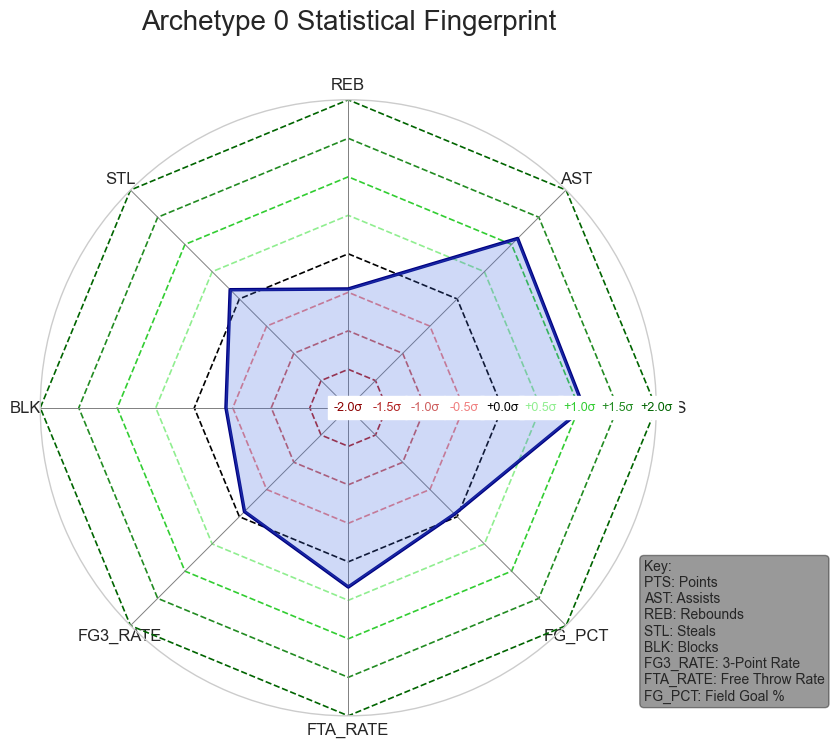

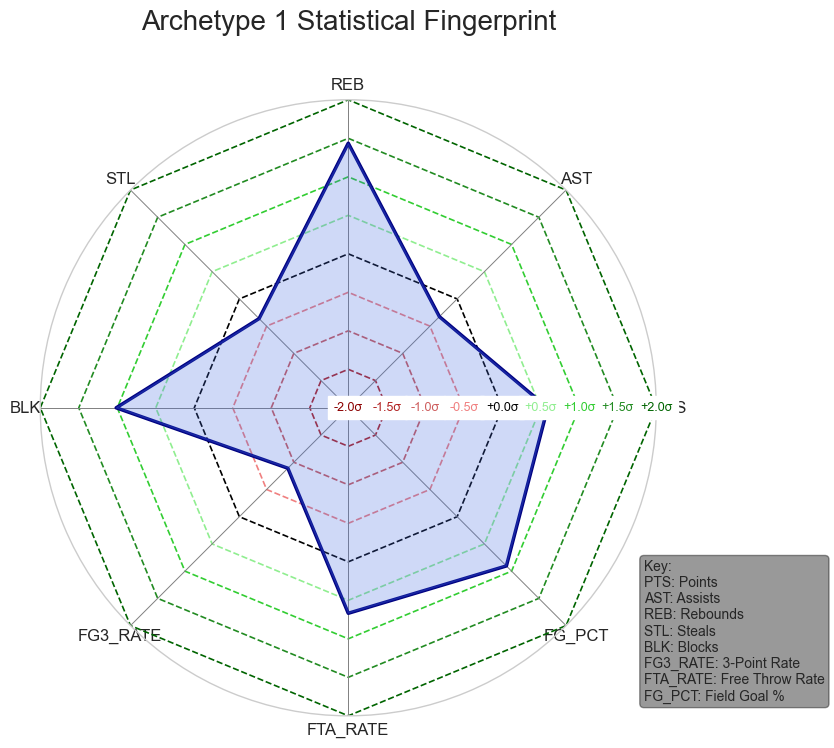

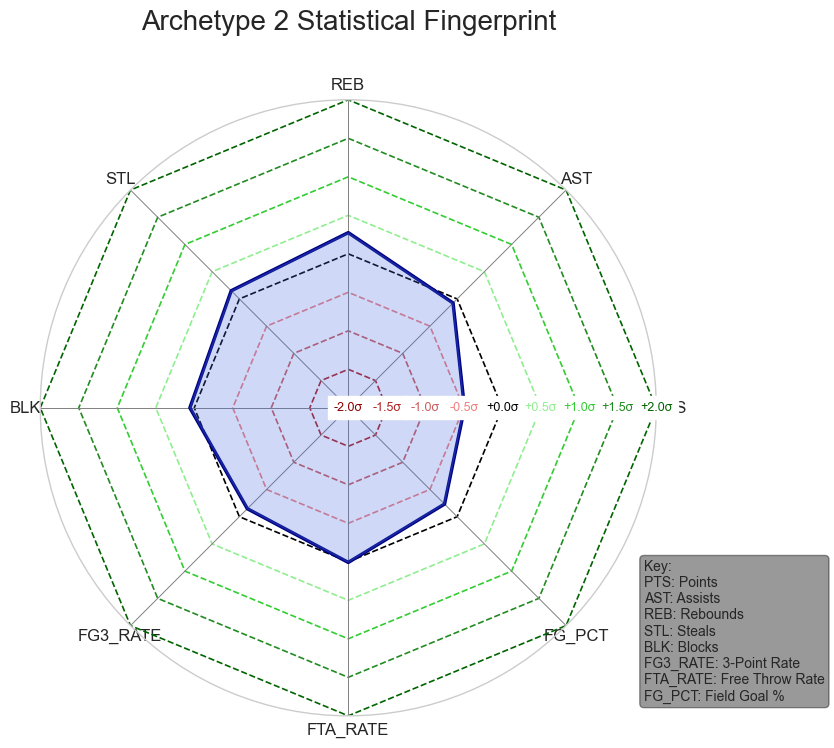

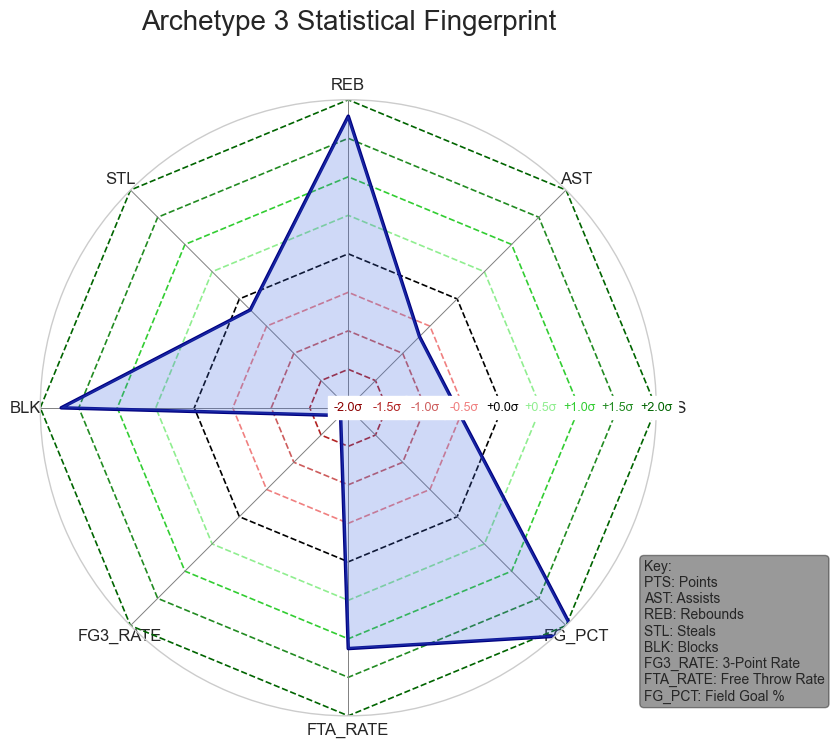

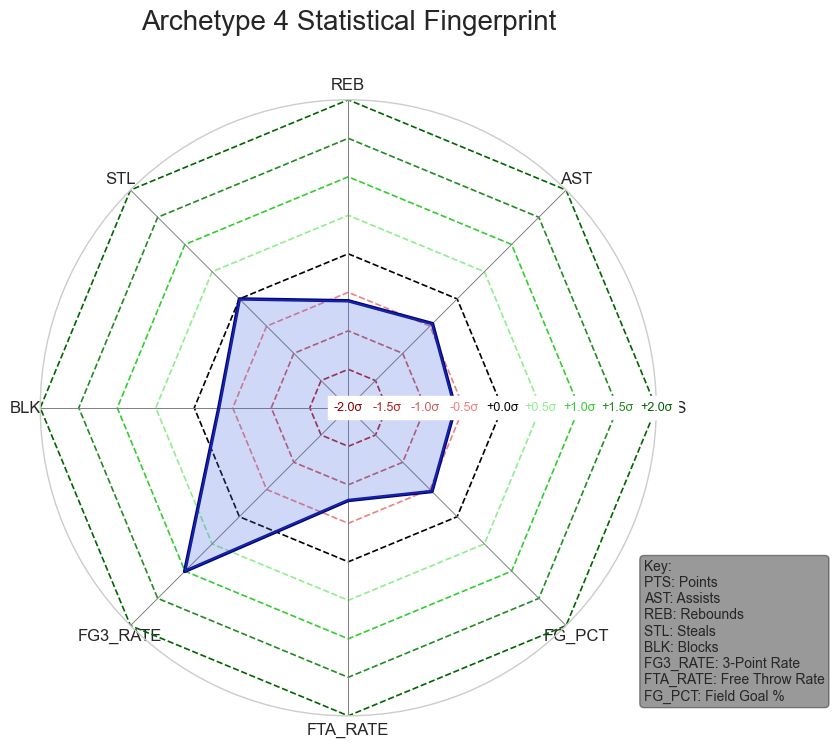

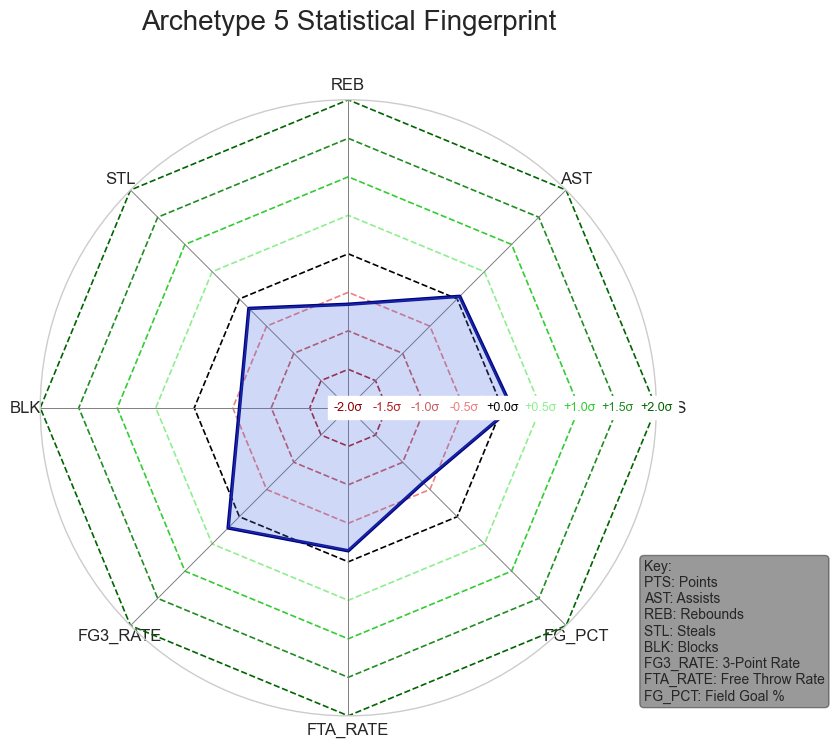

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# --- Radar Chart with Color-Coded SD Rings ---

# Select the 8 key stats for our radar chart axes
radar_features = [
    'PTS', 'AST', 'REB', 'STL', 'BLK', 
    'FG3_RATE', 'FTA_RATE', 'FG_PCT'
]
radar_df = archetype_summary[radar_features]
labels = radar_df.columns
num_vars = len(labels)

# Create the angles for the plot
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1] 

# Define the text for our legend
legend_text = (
    "Key:\n"
    "PTS: Points\n"
    "AST: Assists\n"
    "REB: Rebounds\n"
    "STL: Steals\n"
    "BLK: Blocks\n"
    "FG3_RATE: 3-Point Rate\n"
    "FTA_RATE: Free Throw Rate\n"
    "FG_PCT: Field Goal %"
)

# --- Define the colors for our SD rings ---
grid_color_map = {
    2.0: '#006400',   
    1.5: '#228B22',    
    1.0: '#32CD32',  
    0.5: '#90EE90',   
    0.0: "#000000",  
    -0.5: '#F08080',  
    -1.0: '#CD5C5C',   
    -1.5: '#B22222',   
    -2.0: '#8B0000'
}
grid_levels = sorted(grid_color_map.keys())

# --- Loop through each main cluster and create a chart ---
main_clusters = range(6) # Clusters 0 through 5

for i in main_clusters:
    # Get the values for the current cluster and complete the loop
    values = radar_df.iloc[i].values.flatten().tolist()
    values += values[:1]

    # Create the figure and subplot
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    
    # --- Disable the default grid and labels ---
    ax.grid(False)
    ax.set_yticklabels([])
    
    # --- Manually Draw the Color-Coded Grid Rings ---
    for level in grid_levels:
        color = grid_color_map[level]
        ax.plot(angles, [level] * len(angles), color=color, linestyle='--', linewidth=1.2, zorder=1)
        ax.text(0, level, f'{level:+.1f}σ', color=color, ha='center', va='center', fontsize=9, backgroundcolor='white')
    
    # --- Manually Draw the Spokes ---
    for angle in angles[:-1]:
        ax.plot([angle, angle], [min(grid_levels), max(grid_levels)], color='grey', linestyle='-', linewidth=0.7, zorder=1)

    # --- Plot the Main Player Data on Top ---
    ax.plot(angles, values, color='#000080', linewidth=2.5, linestyle='solid', zorder=2) # Navy Blue outline
    ax.fill(angles, values, color='#4169E1', alpha=0.25, zorder=2) # Royal Blue fill

    # Set the y-axis limits to match our grid
    ax.set_ylim(min(grid_levels), max(grid_levels))
    
    # Add the feature labels at the end of the spokes
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, size=12)
    
    # Add a title
    plt.title(f'Archetype {i} Statistical Fingerprint', size=20, y=1.1)
    
    # Add the embedded legend (in the bottom-right)
    fig.text(0.98, 0.02, legend_text, 
             transform=ax.transAxes,
             fontsize=10, 
             verticalalignment='bottom', 
             horizontalalignment='left',
             bbox=dict(boxstyle='round', facecolor='black', alpha=0.4))
    
    # Save the figure
    plt.savefig(f'archetype_{i}_radar.png', dpi=150, bbox_inches='tight')
    print(f"Saved final chart for Archetype {i}")

plt.show()
